In [1]:
from functools import partial

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import sympy as sy
import y0
from sklearn.metrics import r2_score
from y0.dsl import Variable
from y0.graph import NxMixedGraph

from nocap import scm, utility

np.random.seed(42)
#!pip install pgmpy

## load e. coli network

In [2]:
ecoli_filepath = "./ecoli/ecoli_full_network_no_small_rna.graphml"
ecoli_network = nx.read_graphml(ecoli_filepath)

## get fadR subnetwork

In [3]:
# fadR
fadr_graph = utility.get_subgraph_from_nodes(ecoli_network, ["fadR"], descendants_only=False)
fadr_graph_dag = utility.convert_to_acyclic_graph(fadr_graph, "fadR")
fadr_graph_mixed = NxMixedGraph.from_str_edges(directed=fadr_graph_dag.edges)

print(f"{len(fadr_graph_mixed.directed.nodes)} nodes")
print(f"{len(fadr_graph_mixed.directed.edges)} edges")

109 nodes
440 edges


## simulate data for fadR subnetwork using linear model

In [4]:
# fadr_node_generators = {
#     node: partial(np.random.normal, loc=0, scale=1) for node in fadr_graph_mixed.nodes()
# }
# fadr_edge_weights = {
#     edge: np.random.normal(loc=0, scale=1) for edge in fadr_graph_mixed.directed.edges()
# }

fadr_node_generators = {
    node: partial(np.random.normal, loc=0, scale=1) for node in fadr_graph_mixed.nodes()
}
# fadr_edge_weights = {
#     edge: np.random.uniform(low=-1, high=1) for edge in fadr_graph_mixed.directed.edges()
# }

fadr_edge_weights = {
    edge: np.random.normal(loc=0, scale=1) for edge in fadr_graph_mixed.directed.edges()
}

n_samples = 10000

fadr_df_lscm = scm.simulate_lscm(
    graph=fadr_graph_mixed,
    node_generators=fadr_node_generators,
    edge_weights=fadr_edge_weights,
    n_samples=n_samples,
)

print(fadr_df_lscm.head())

       fabR     c0293      rcdA      btsR      adiY      basR      glrR  \
0  0.384065 -0.032695 -2.067442 -0.089120 -1.304470  0.669673  0.366598   
1 -0.603985  0.086590 -0.155677  1.167782  0.254421  0.337603 -0.411877   
2  0.198085 -0.144360 -0.573662 -0.546859 -0.032753 -0.543425 -0.712846   
3  1.770801 -0.626967  1.812449  0.707752 -0.562467  0.632408  0.972554   
4 -0.517611  0.223788 -0.016423  1.188393  2.526932 -0.530869 -0.489439   

       glaR      nsrR      alpA  ...       gadW        gadE       rcsA  \
0 -0.939880 -0.513867 -1.059214  ...   9.386009  -47.905948  -4.836247   
1 -0.487606 -0.432558  0.394452  ...  50.576143 -190.280067  -8.301108   
2  0.106430 -0.254977  1.503993  ... -92.289561  262.513736  12.716043   
3  0.621810 -1.570225 -0.727137  ...  21.733040  -98.387708  -5.584847   
4  1.044161  0.681891  1.846707  ... -38.315573  160.332343   6.918391   

        csgD       flhC       flhD        iclR        aceA       aceB  \
0   4.412213 -35.708894  11.809

## calibrate linear fadR model to data

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_45400/2912437397.py:1: UserWarning: Correlation matrix contains 1 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 4.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_45400/2912437397.py:1: UserWarning: Correlation matrix contains 16 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 17.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_45400/2912437397.py:1: UserWarning: Correlation matrix contains 16 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 17.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6

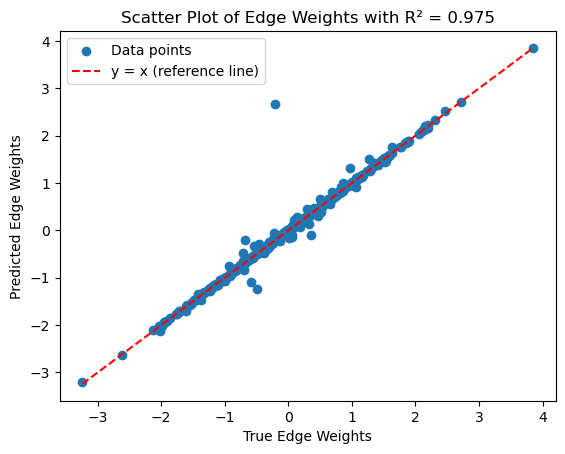

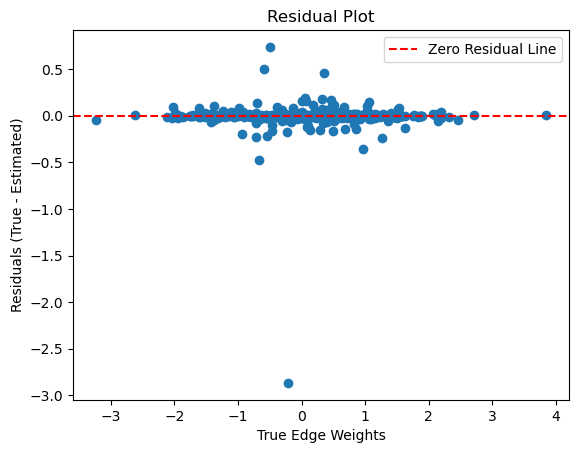

In [5]:
fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)


def plot_scatter_with_r2(exp_edges, pred_edges):
    exp_values = np.array([exp_edges[edge] for edge in exp_edges])
    pred_values = np.array([pred_edges[edge] for edge in pred_edges])

    # Calculate R^2 value
    r2 = r2_score(exp_values, pred_values)

    # Create scatter plot
    plt.scatter(exp_values, pred_values, label="Data points")
    max_val = max(np.max(exp_values), np.max(pred_values))
    min_val = min(np.min(exp_values), np.min(pred_values))
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label=f"y = x (reference line)")
    plt.xlabel("True Edge Weights")
    plt.ylabel("Predicted Edge Weights")
    plt.title(f"Scatter Plot of Edge Weights with R² = {r2:.3f}")
    plt.legend()
    plt.show()


def plot_residuals(true_weights, estimated_weights):
    true_values = np.array([value for value in true_weights.values()])
    estimated_values = np.array([value for value in estimated_weights.values()])

    # Calculate residuals
    residuals = true_values - estimated_values

    # Scatter plot of residuals
    plt.scatter(true_values, residuals)
    plt.axhline(0, color="r", linestyle="--", label="Zero Residual Line")
    plt.xlabel("True Edge Weights")
    plt.ylabel("Residuals (True - Estimated)")
    plt.title("Residual Plot")
    plt.legend()
    plt.show()


# Example usage
plot_scatter_with_r2(fadr_edge_weights, fadr_edge_weight_estimates)

plot_residuals(fadr_edge_weights, fadr_edge_weight_estimates)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  2.,  1.,  3.,  1.,  3.,  3.,  2.,  4.,  5.,  5.,
         5.,  8.,  7.,  4.,  9.,  5.,  7., 14., 13.,  5., 10.,  8., 14.,
         8.,  9., 12., 13., 13., 12., 11., 15., 13., 14., 14., 12.,  9.,
        12., 10., 14.,  8., 13.,  7., 11.,  8.,  3.,  6.,  2.,  5.,  4.,
         4.,  6.,  7.,  1.,  0.,  3.,  4.,  2.,  0.,  2.,  3.,  3.,  0.,
         1.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-3.19476332, -3.12431435, -3.05386539, -2.98341643, -2.91296747,
        -2.84251851, -2.77206954, -2.70162058, -2.63117162, -2.56072266,
        -2.4902737 , -2.41982474, -2.34937577, -2.27892681, -2.20847785,
        -2.13802889, -2.06757993, -1.99713096, -1.926682  , -1.85623304,
        -1.78578408, -1.71533512, -1.64488616, -1.57443719, -1.50398823,
        -1.43353927, -1.36309031, -1.29264135, -1.22219238, -1.151743

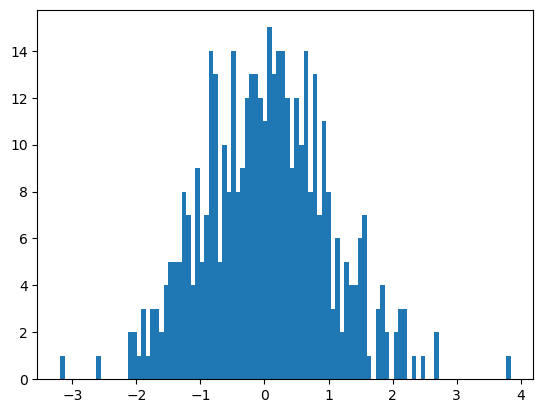

In [6]:
fadr_edge_weight_values = np.array([value for value in fadr_edge_weights.values()])
fadr_edge_weight_values_predicted = np.array(
    [value for value in fadr_edge_weight_estimates.values()]
)

#plt.hist(fadr_edge_weight_values, bins=100)
plt.hist(fadr_edge_weight_values_predicted, bins=100)

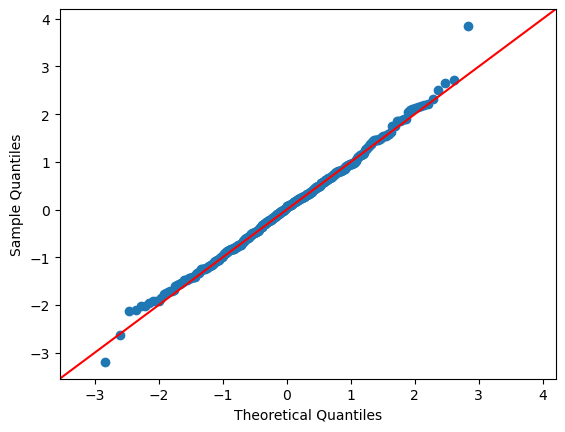

In [7]:
import numpy as np
import pylab as py
import statsmodels.api as sm

# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code
# the graph look different than shown below.

# Random data points generated
data_points = np.array([v for v in fadr_edge_weight_estimates.values()])

# fadr_edge_weight_estimates

sm.qqplot(data_points, line="45")
py.show()

## perform intervention on fadR subnetwork and simulate interventional data from calibrated model

In [8]:
fadr_intervened_lscm_calibrated = scm.intervene_on_lscm(
    original_graph=fadr_graph_mixed,
    intervention_node=((Variable("fadR"), 10.0)),
    original_node_generators=fadr_node_generators,
    original_edge_weights=fadr_edge_weight_estimates,
)

fadr_df_lscm_calibrated_intervened = pd.DataFrame(
    {
        trial: {
            variable.name: values
            for variable, values in fadr_intervened_lscm_calibrated.trial().items()
        }
        for trial in range(n_samples)
    }
).T

print(fadr_df_lscm_calibrated_intervened.head())

       fabR     c0293  fadR      rcdA      btsR      adiY      basR      glrR  \
0 -0.253118 -1.904703  10.0  1.744087 -0.822342  0.103354 -0.234237  1.007853   
1  0.198233  0.744524  10.0  0.118041 -0.750188  0.257439  1.838653  2.610353   
2 -0.446999  1.051504  10.0 -1.282194  2.511619  0.523905 -0.947238 -1.950723   
3 -0.466407 -0.041468  10.0  0.478305  1.029340 -1.607704 -0.069824 -0.762152   
4 -0.759699 -0.191055  10.0  1.531902 -1.179717  0.624253 -0.564768 -0.809370   

       glaR      nsrR  ...       gadW        gadE       rcsA       csgD  \
0  0.704588  0.919492  ... -43.382098  150.476383   5.693621  29.393833   
1  2.104149 -0.662533  ...  23.161739  -76.563051  -5.436138 -20.595237   
2 -1.164950 -1.272876  ...  60.455020 -226.960803  -5.987100 -53.233278   
3 -0.328958  0.549924  ...  -3.846710  -51.550860  -6.165538  15.792652   
4 -0.114465  0.483536  ... -56.683506  208.393849  11.673909  39.622314   

        flhC       flhD        iclR        aceA        aceB   

## perform intervention on fadR subnetwork and simulate interventional data from actual model

In [9]:
fadr_intervened_lscm = scm.intervene_on_lscm(
    original_graph=fadr_graph_mixed,
    intervention_node=((Variable("fadR"), 10.0)),
    original_node_generators=fadr_node_generators,
    original_edge_weights=fadr_edge_weights,
)

fadr_df_lscm_intervened = pd.DataFrame(
    {
        trial: {variable.name: values for variable, values in fadr_intervened_lscm.trial().items()}
        for trial in range(n_samples)
    }
).T

print(fadr_df_lscm_intervened.head())

       fabR     c0293  fadR      rcdA      btsR      adiY      basR      glrR  \
0  0.718863  2.020001  10.0 -0.591883  0.636196 -1.132677  1.050044 -0.979324   
1  0.749757 -0.522308  10.0  0.170877 -0.465833 -0.025226  0.069478  0.841002   
2  1.048295 -0.215257  10.0 -0.333588  0.465659  0.934905 -0.251603  0.261149   
3 -0.846651  1.346772  10.0 -0.131846  0.695677  0.003300  0.390280  1.224750   
4  0.535894  0.622148  10.0  0.458859  0.615337 -2.973769  0.142422 -0.606775   

       glaR      nsrR  ...       gadW        gadE       rcsA       csgD  \
0  0.522743  0.523324  ...  -4.286843   20.622396   2.014462  10.177961   
1 -0.245908 -1.930061  ...  63.508496 -219.256088 -13.440629 -46.233378   
2 -1.675011  0.677211  ...  33.776734  -96.685541  -5.001067 -23.886796   
3  0.717897  0.894222  ...  16.393378  -40.106369  -1.406769  -8.099256   
4  0.996257  0.320168  ... -23.756185   72.335904   3.978809  22.620406   

        flhC       flhD        iclR        aceA       aceB    

## calculate expected and predicted average treatment effect of fadR linear model

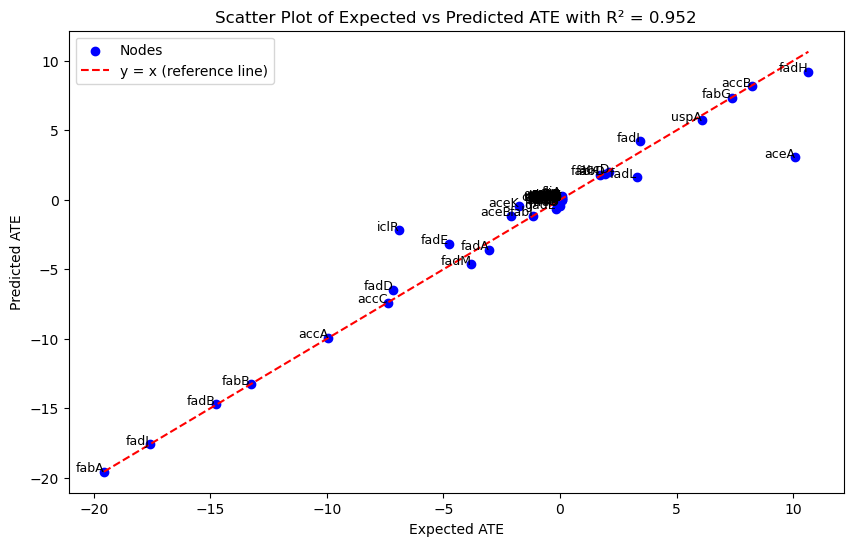

In [10]:
targets_list = [
    node for node in fadr_graph_mixed.nodes() if node.name != "fadR"
]  # all nodes except intervened node 'fadR'


expected_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_df_lscm, fadr_df_lscm_intervened, targets_list
)
predicted_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_df_lscm, fadr_df_lscm_calibrated_intervened, targets_list
)

# print(f"expected ATE:{expected_fadr_ATE}")
# print(f"actual ATE:{predicted_fadr_ATE}")


# Extract values in the same order
expected_values = np.array([expected_fadr_ATE[node] for node in expected_fadr_ATE])
predicted_values = np.array([predicted_fadr_ATE[node] for node in predicted_fadr_ATE])

# Calculate R2 value
r2 = r2_score(expected_values, predicted_values)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(expected_values, predicted_values, color="blue", label="Nodes")

# Add node labels
for i, node in enumerate(expected_fadr_ATE.keys()):
    plt.text(expected_values[i], predicted_values[i], node, fontsize=9, ha="right")

# Reference line (y=x)
max_val = max(np.max(expected_values), np.max(predicted_values))
min_val = min(np.min(expected_values), np.min(predicted_values))
plt.plot([min_val, max_val], [min_val, max_val], "r--", label=f"y = x (reference line)")

# Add labels and title
plt.xlabel("Expected ATE")
plt.ylabel("Predicted ATE")
plt.title(f"Scatter Plot of Expected vs Predicted ATE with R² = {r2:.3f}")
plt.legend()

plt.show()

## Non-linear data generation using SERGIO (modified Hill equation)

In [12]:
# sergio data

fadr_nominal_data = 0

fadr_intervened_data_expected = 0

fadr_intervened_data_predicted = 0

fadr_ate_expected = 0

fadr_ate_predicted = 0

# microsplit data